In [16]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

In [17]:
img_shape = (28, 28, 1)
batch_size = 16

# 2D plane for latent space
latent_dim = 2

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                 padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                 padding='same', activation='relu',
                 strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                 padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                 padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [18]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                             mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

### Decoder Implementation

In [19]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(decoder_input)

x = layers.Reshape(shape_before_flattening[1:])(x)

x = layers.Conv2DTranspose(32, 3,
                          padding='same',
                          activation='relu',
                          strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                 padding='same',
                 activation='sigmoid')(x)

decoder = Model(decoder_input, x)

z_decoded = decoder(z)

### Custom Loss Layer

In [20]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
y = CustomVariationalLayer()([input_img, z_decoded])

In [21]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 28, 28, 32)   320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_14 

/home/dhodun/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Output "custom_variational_layer_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_3" during training.


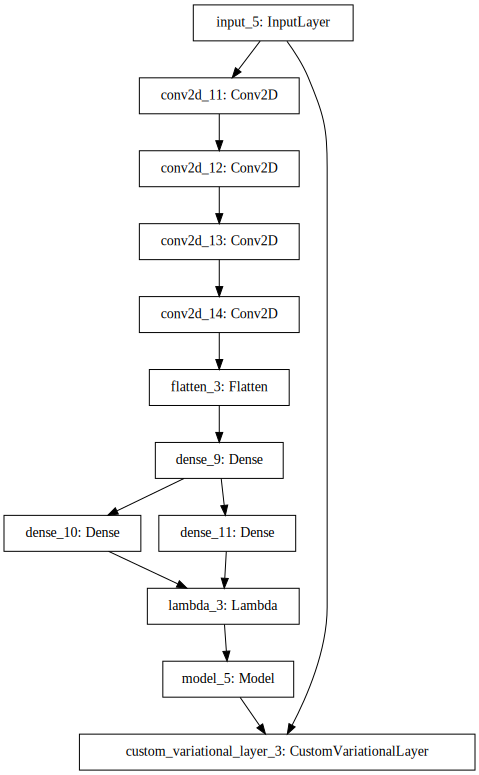

In [22]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(vae).create(prog='dot', format='svg'))

In [24]:
(x_train, _), (x_test, y_test) = mnist.load_data()

# prep
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 25s 419us/step - loss: 0.2143 - val_loss: 0.2004
Epoch 2/10
60000/60000 [==============================] - 23s 389us/step - loss: 0.1969 - val_loss: 0.1931
Epoch 3/10
60000/60000 [==============================] - 23s 389us/step - loss: 0.1921 - val_loss: 0.1911
Epoch 4/10
60000/60000 [==============================] - 23s 389us/step - loss: 0.1895 - val_loss: 0.1882
Epoch 5/10
60000/60000 [==============================] - 23s 389us/step - loss: 0.1875 - val_loss: 0.1865
Epoch 6/10
60000/60000 [==============================] - 23s 390us/step - loss: 0.1860 - val_loss: 0.1868
Epoch 7/10
60000/60000 [==============================] - 23s 388us/step - loss: 0.1849 - val_loss: 0.1851
Epoch 8/10
60000/60000 [==============================] - 23s 389us/step - loss: 0.1841 - val_loss: 0.1835
Epoch 9/10
60000/60000 [==============================] - 23s 389us/step - loss: 0.1834 - val_

### MNIST model trained, test decoder

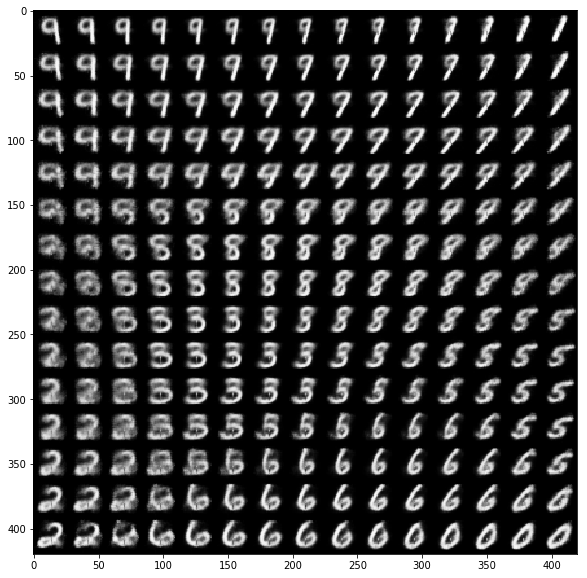

In [27]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
        
plt.figure(figsize=(10,10))
plt.imshow(figure, cmap='Greys_r')
plt.show()